In [135]:
# Load the feature sim from the checkpoint
import torch
# format is checkpoints/feature_sim_0.pt, checkpoints/feature_sim_19, checkpoints/feature_sim_39
# checkpoint_every = 30
# max_checkpoint = 420
checkpoint_every = 200
# max_checkpoint = 49000
max_checkpoint = 31200
# checkpoint_every = 10
# max_checkpoint = 60

# all_checkpoint_names = [f"checkpoints/feature_sim_{i}.pt" for i in list(range(19, 360, 20))]
all_checkpoint_names = [f"checkpoints/ce_loss_and_activations_{i}.pt" for i in list(range(checkpoint_every, max_checkpoint, checkpoint_every))]

all_acts = []
noisy_ces = []
w_diffs = []

logprobs = True

original_name = "checkpoints/first_batch_info_skip_first_token.pt"
first_checkpoint = torch.load(original_name)
ce_key, act_key, tok_key = first_checkpoint.keys()
orig_ce_loss = first_checkpoint[ce_key]
tokens = first_checkpoint[tok_key]

noisy_ces.append(orig_ce_loss)

for checkpoint_name in all_checkpoint_names:
    checkpoint_noise = torch.load(checkpoint_name)
    ce_diff_key, activation_key, w_diff_key  = checkpoint_noise.keys()
    activations = checkpoint_noise[activation_key]
    ce_diffs = checkpoint_noise[ce_diff_key]
    w_diff = checkpoint_noise[w_diff_key]
    all_acts.append(activations)
    noisy_ces.append(ce_diffs)
    w_diffs.append(w_diff.item())

all_acts = torch.stack(all_acts, dim=0)
noisy_ces = torch.stack(noisy_ces, dim=0)
if logprobs:
    noisy_ces *= -1

In [136]:
noisy_ces.mean(dim=(1,2))

tensor([-1.5420, -1.5391, -1.5439, -1.5420, -1.5479, -1.5352, -1.5537, -1.5488,
        -1.5586, -1.5586, -1.5723, -1.5684, -1.5703, -1.5703, -1.5645, -1.5859,
        -1.5762, -1.5859, -1.5859, -1.5859, -1.5938, -1.6006, -1.5967, -1.5928,
        -1.6045, -1.6074, -1.6123, -1.6133, -1.6230, -1.6250, -1.6123, -1.6230,
        -1.6240, -1.6172, -1.6279, -1.6338, -1.6416, -1.6270, -1.6309, -1.6426,
        -1.6338, -1.6416, -1.6445, -1.6582, -1.6611, -1.6602, -1.6836, -1.6670,
        -1.6738, -1.6699, -1.6738, -1.6719, -1.6807, -1.6807, -1.6982, -1.6875,
        -1.6846, -1.6973, -1.6777, -1.6963, -1.7080, -1.6943, -1.7109, -1.7100,
        -1.7148, -1.7061, -1.7178, -1.7207, -1.7080, -1.7295, -1.7266, -1.7344,
        -1.7422, -1.7246, -1.7363, -1.7422, -1.7383, -1.7363, -1.7383, -1.7529,
        -1.7344, -1.7529, -1.7529, -1.7480, -1.7520, -1.7607, -1.7607, -1.7432,
        -1.7656, -1.7617, -1.7686, -1.7754, -1.7773, -1.7695, -1.7725, -1.7773,
        -1.7773, -1.7920, -1.7910, -1.79

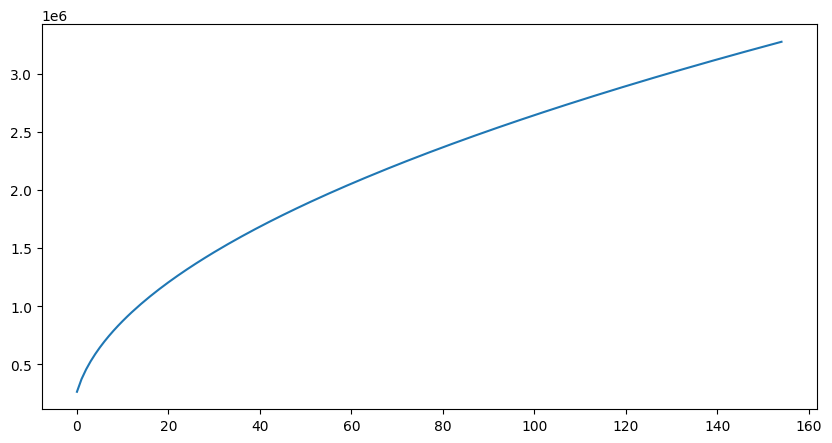

In [137]:
# plot weight diff
import matplotlib.pyplot as plt
import numpy as np

# plot the weight diff
plt.figure(figsize=(10, 5))
plt.plot(w_diffs)

In [138]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# model_name = "HuggingFaceTB/SmolLM-135M"
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# import matplotlib.pyplot as plt
# for i in range(1, 10):
#     plt.figure()
#     rand_int = torch.randint(0, noisy_ces.shape[1], size = (2,))
#     for j in rand_int:
#         rand_seq_length_add = torch.randint(0, 15, size=(1,))[0]
#         col = 3*rand_seq_length_add
#         print(tokenizer.decode(tokens[j, :col+1]))
#         print("---------------------------------------------")
#         plt.plot(noisy_ces[:, j, col])
#     plt.ylabel("CE Diff")
#     plt.xlabel("Checkpoint")
#     plt.show()

In [139]:
N = 300 # 1k*127
# Alt TODO: Just a random set of seq_pos & batches
reduced_logprobs = noisy_ces[:, :N].flatten(start_dim=1)
reduced_logprobs.shape

torch.Size([156, 38100])

In [164]:
noisy_ces[0].numel()

406400

In [6]:
# We now want a d_point, d_point matrix (~ 37GB)
mem_GB = 2*(reduced_logprobs.shape[-1]**2)/(1024**3) 
print(f"Exptected Matrix: {mem_GB:.1f}GB")

Exptected Matrix: 1.2GB


In [140]:
def calculate_covariance_matrix(data):
    centered_data = data - data.mean(dim=0)
    
    # Calculate covariance matrix
    # The formula is (1/N) * X.T @ X where X is the centered data
    N = data.shape[0]  # Number of checkpoints
    cov_matrix = (centered_data.T @ centered_data) / N
    
    return cov_matrix
# Now we want to take the covariance across the full reduced_logprobs
# First we need to remove the mean across each checkpoint
cov_matrix = calculate_covariance_matrix(reduced_logprobs)
cov_matrix.shape

torch.Size([38100, 38100])

In [141]:
corr_matrix = torch.corrcoef(reduced_logprobs.T)
corr_matrix.shape

torch.Size([38100, 38100])

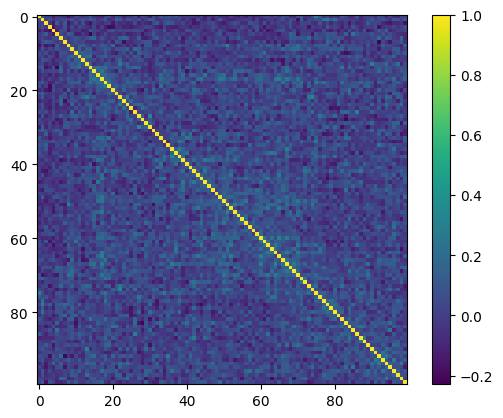

In [142]:
# plot the first 100x100 of the cov_matrix
plt.imshow(corr_matrix[:100, :100].cpu().numpy())
plt.colorbar()
plt.show()

In [160]:
# Now do SVD on the corr_matrix
svd_N = 8000
U, S, V = torch.svd(cov_matrix[:svd_N, :svd_N].to(torch.float32))
# plot S

S > 0.1:  155


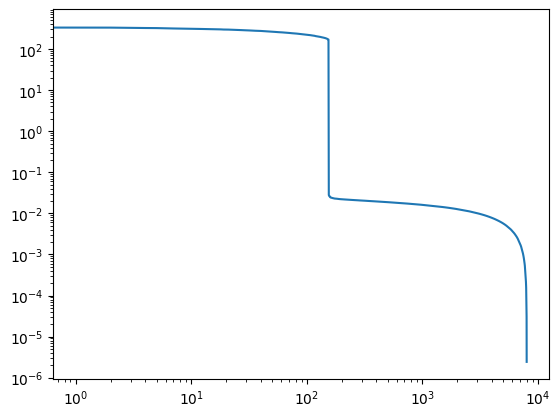

In [161]:
print("S > 0.1: ", (S > 0.1).sum().item())
plt.plot(S.cpu().numpy())
plt.yscale("log")
plt.xscale("log")
plt.show()

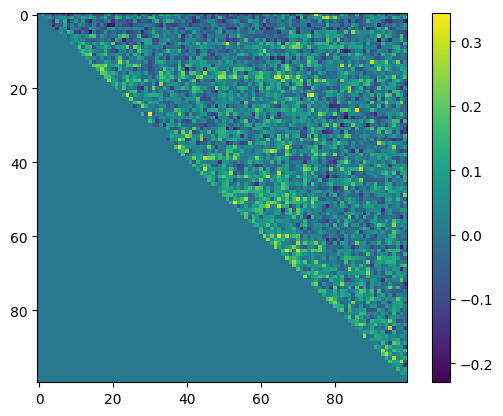

In [145]:
# set diagonal  & upper triangle to 0
corr_matrix.fill_diagonal_(0)
corr_matrix = torch.triu(corr_matrix)
# plot the first 100x100 of the corr_matrix
plt.imshow(corr_matrix[:100, :100].cpu().numpy())
plt.colorbar()
plt.show()

tensor([26.7500, 22.7969, 22.0938, 21.7188, 20.7969, 20.7031, 20.1719, 19.6719,
        19.5781, 19.0000], dtype=torch.float16)


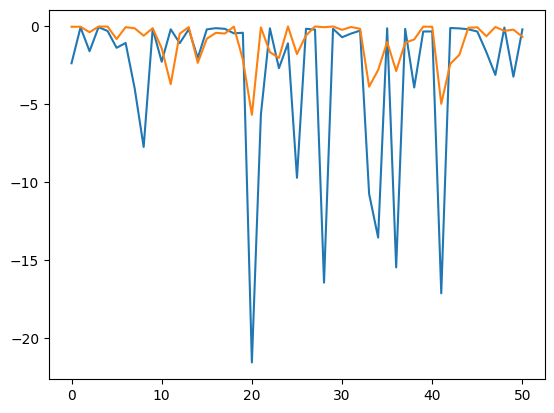

In [118]:
noisy_ces.shape, reduced_logprobs.shape
v, d_idx = cov_matrix.max(dim=1).values.topk(10)
# v, d_idx = corr_matrix.max(dim=1).values.topk(10)
print(v)
var = 0
cov1 = reduced_logprobs[:, d_idx[var]]
max_ind = corr_matrix[d_idx[var]].argmax()
cov2 = reduced_logprobs[:, max_ind]
# plot cov1 and cov2
plt.plot(cov1)
plt.plot(cov2)
plt.show()

In [158]:
# target_d_point = sim_matrix.shape[0]-1
# target_d_point = corr_matrix.shape[0]-150
# v, d_idx = cov_matrix.max(dim=1).values.topk(30)
v, d_idx = corr_matrix.max(dim=1).values.topk(10)

target_d_point = d_idx[3]
# top_vals, top_ind = cov_matrix[target_d_point].topk(10)
top_vals, top_ind = corr_matrix[target_d_point].topk(10)
_, cols = tokens.shape
rows = N
# unravel convert back into normal indices
# Convert the top indices back to row, col indices for tokens
# top_ind contains the flattened indices of the most similar tokens
# We need to convert these back to 2D indices to look them up in the tokens tensor

# Calculate the row and column indices for each top index
top_rows = top_ind // cols# Integer division to get row indices
top_cols = top_ind % cols # Modulo to get column indices

# Print the top similar tokens with their indices and similarity values
tar_row = target_d_point // cols
tar_col = target_d_point % cols

print("Top similar tokens:")
for i, (idx, val) in enumerate(zip(top_ind, top_vals)):
    row, col = top_rows[i], top_cols[i]
    print(f"Index: {idx}, Position: ({row}, {col}), Similarity: {val:.4f}")


Top similar tokens:
Index: 9719, Position: (76, 67), Similarity: 0.5439
Index: 4688, Position: (36, 116), Similarity: 0.3696
Index: 3179, Position: (25, 4), Similarity: 0.3687
Index: 30607, Position: (241, 0), Similarity: 0.3628
Index: 29253, Position: (230, 43), Similarity: 0.3489
Index: 32805, Position: (258, 39), Similarity: 0.3479
Index: 24969, Position: (196, 77), Similarity: 0.3477
Index: 17685, Position: (139, 32), Similarity: 0.3425
Index: 28751, Position: (226, 49), Similarity: 0.3425
Index: 29216, Position: (230, 6), Similarity: 0.3381


In [159]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "HuggingFaceTB/SmolLM-135M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# first print target token
tar_tok = tokens[tar_row, :tar_col+1]
print(tokenizer.decode(tar_tok))
print("-------------------Target token above------------------------")

for row_idx, col_idx in zip(top_rows, top_cols):
    r = tokens[row_idx]
    tok = r[:col_idx + 1]
    print(tokenizer.decode(tok))
    print("----------------------------------")
    # We want to print out the tokens up to the top_col

 13: Leveraging Technology in Modern Marketing: Telemarketing and Chatbot Marketing

In today's fast-paced business environment, technology has become an essential component of marketing strategies. Among various technological advancements that have transformed marketing are telemarketing and chatbot marketing. This chapter delves into these two modern marketing techniques, their benefits, challenges, and best practices. We will also explore how they align with current marketing trends and support businesses in achieving their objectives.

Telemarketing: Defining the Landscape
------------------------------------

### What is Telemarketing?

-------------------Target token above------------------------
 we're going to explore the fascinating world of military fortifications and bastion fortresses. Have you ever seen a real castle before? Or perhaps played a game where you had to build your own stronghold? If so, then you already have an idea of what we'll learn about today!

Firstly, l

In [7]:
# Let's do cos-sim across checkpoints ie reduced_ce_diff.T @ reducted_ce_diff (but normed)
# norm over checkpoints, so each datapoint sums to one
# Wait some of these are negative? 
# reduced_ce_diff shape is [checkpoints, d_points]
normed_ce_diff = reduced_ce_diff / reduced_ce_diff.norm(dim=0, keepdim=True)

# Now we want to do a matrix mult, but reduced
# M = 1000
# reduced_normed = normed_ce_diff[:, :M]
sim_matrix = normed_ce_diff.T @ normed_ce_diff

sim_matrix = sim_matrix.fill_diagonal_(0)
# Zero out upper triangle to avoid counting pairs twice
mask = torch.triu(torch.ones_like(sim_matrix), diagonal=1)
sim_matrix = sim_matrix.masked_fill(mask.bool(), 0)

In [ ]:
normed_ce_diff.shape

In [ ]:
# Plot the sim matrix
plot_reduction = 100
import matplotlib.pyplot as plt
plt.imshow(sim_matrix[:plot_reduction, :plot_reduction].cpu().numpy())
plt.colorbar(label='Similarity')
plt.show()

In [ ]:
# target_d_point = sim_matrix.shape[0]-1
target_d_point = sim_matrix.shape[0]-125
top_vals, top_ind = sim_matrix[target_d_point].topk(10)
_, cols = tokens.shape
rows = N
# unravel convert back into normal indices
# Convert the top indices back to row, col indices for tokens
# top_ind contains the flattened indices of the most similar tokens
# We need to convert these back to 2D indices to look them up in the tokens tensor

# Calculate the row and column indices for each top index
top_rows = top_ind // rows  # Integer division to get row indices
top_cols = top_ind % rows   # Modulo to get column indices

# Print the top similar tokens with their indices and similarity values
tar_row = target_d_point // rows
tar_col = target_d_point % rows

print("Top similar tokens:")
for i, (idx, val) in enumerate(zip(top_ind, top_vals)):
    row, col = top_rows[i], top_cols[i]
    print(f"Index: {idx}, Position: ({row}, {col}), Similarity: {val:.4f}")


In [ ]:
d_idx = 2643
sim_matrix.max(dim=0).values.topk(10), sim_matrix[d_idx].max(), normed_ce_diff[:, d_idx], reduced_ce_diff[:, d_idx]

In [ ]:
reduced_ce_diff.T[rand_ind].shape, reduced_ce_diff.T[rand_ind].shape, line.shape, num_checkpoints, torch.arange

In [ ]:
import matplotlib.pyplot as plt
datapoints_per_plot = 5
num_checkpoints = reduced_ce_diff.shape[0]
for _ in range(10):
    plt.figure()
    
    rand_ind = torch.randint(0, reduced_ce_diff.shape[-1], size=(datapoints_per_plot, 1)).squeeze()
    for d_idx in range(datapoints_per_plot):
        line = reduced_ce_diff.T[rand_ind[d_idx]]
        x_axis = torch.arange(num_checkpoints)
        plt.plot(x_axis, line)
        plt.plot()
    plt.show()

In [ ]:
# rand_ind = torch.randint(0, max)
reduced_ce_diff.T[rand_ind]

In [ ]:
target_d_point // cols, target_d_point % cols, 

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "HuggingFaceTB/SmolLM-135M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# first print target token
tar_tok = tokens[tar_row, :tar_col+1]
print(tokenizer.decode(tar_tok))
print("-------------------Target token above------------------------")

for row_idx, col_idx in zip(top_rows, top_cols):
    r = tokens[row_idx]
    tok = r[:col_idx + 1]
    print(tokenizer.decode(tok))
    print("----------------------------------")
    # We want to print out the tokens up to the top_col


In [ ]:
# Apply SVD to sim_matrix w/ gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sim_matrix = sim_matrix.to(device).to(torch.float32)
U, S, V = torch.svd(sim_matrix)
U.shape, S.shape, V.shape
S.topk(100)

In [ ]:
# plot S
import matplotlib.pyplot as plt
plt.plot(S.cpu().numpy())
plt.yscale("log")

In [ ]:
import torch
import random
device = torch.device()
def randomized_svd(matrix, rank, oversampling=2, n_iter=2):
    n_rows, n_cols = matrix.size()
    
    # Generate random test matrix
    test_matrix = torch.randn(n_cols, rank + oversampling).to(matrix.device)
    
    # Project the matrix
    projection = matrix @ test_matrix
    for _ in range(n_iter):
        projection = matrix @ (matrix.T @ projection)
    
    # Orthogonalize the projection
    Q, _ = torch.linalg.qr(projection)
    
    # Project the original matrix
    B = matrix.T @ Q
    
    # Compute SVD on the smaller projected matrix
    U_hat, S, V = torch.linalg.svd(B, full_matrices=False)
    U = Q @ U_hat
    
    return U[:, :rank], S[:rank], V[:rank, :]

In [ ]:
# Apply SVD to sim_matrix
# Apply SVD to sim_matrix using GPU, but handle memory constraints
import torch

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get matrix dimensions
n = sim_matrix.shape[0]
k = min(n, 10)  # Number of singular values/vectors to compute

# Move sim_matrix to GPU if possible
try:
    # Try to move the entire matrix to GPU
    sim_matrix_gpu = sim_matrix.to(device)
    
    # Use torch.svd_lowrank which is memory efficient
    U, S, V = torch.svd_lowrank(sim_matrix_gpu, q=k)
    print(f"Successfully computed top {k} singular values on {device}")
    print(f"Largest singular value: {S[0]}")
    print(f"Smallest computed singular value: {S[-1]}")
    
    # Move results back to CPU if needed
    U, S, V = U.cpu(), S.cpu(), V.cpu()
    
except RuntimeError as e:
    print(f"Full matrix SVD failed due to GPU memory constraints: {e}")
    
    # Alternative approach: iterative SVD using smaller chunks
    print("Trying alternative chunked approach with GPU acceleration...")
    
    # Initialize random matrix for power iteration
    v = torch.randn(n, k, device=device)
    v = v / v.norm(dim=0, keepdim=True)
    
    # Power iteration to find dominant eigenvectors
    for i in range(10):  # Number of iterations
        # Matrix-vector product in chunks to save memory
        chunk_size = 1000
        result = torch.zeros_like(v)
        
        for j in range(0, n, chunk_size):
            end = min(j + chunk_size, n)
            # Process chunks on GPU in smaller pieces
            chunk = sim_matrix[j:end, :].to(device)
            chunk_result = chunk @ (sim_matrix.T.to(device) @ v)
            result[j:end] = chunk_result
            # Clear GPU cache after each chunk
            torch.cuda.empty_cache()
            
        # Orthogonalize on GPU
        v, _ = torch.linalg.qr(result)
        print(f"Iteration {i+1}/10 completed")
    
    # Compute singular values on GPU
    S = torch.zeros(k, device=device)
    for i in range(k):
        # Compute one singular value at a time to save memory
        v_i = v[:, i].reshape(-1, 1)
        # Process in chunks
        sv = 0
        for j in range(0, n, chunk_size):
            end = min(j + chunk_size, n)
            chunk = sim_matrix[j:end, :].to(device)
            sv += (v_i[j:end].T @ chunk @ chunk.T @ v_i[j:end]).item()
        S[i] = torch.sqrt(torch.tensor(sv, device=device))
    
    print(f"Computed approximate top {k} singular values on {device}")
    print(f"Largest singular value: {S[0]}")
    print(f"Smallest computed singular value: {S[-1]}")
    
    # Move results back to CPU
    S = S.cpu()

In [ ]:
((reduced_ce_diff[:, 0] / reduced_ce_diff[:, 0].norm()))

In [ ]:
reduced_ce_diff[:, 0]

In [ ]:
reduced_ce_diff.norm(dim=0).shape

In [ ]:
EPS = 1e-3 # Any lower & we get infs. past 1e-8, we get nans
log_odds = torch.log((noisy_ce_diff + EPS)/(orig_ce_loss + EPS))
print(f"Num of Nans: ", log_odds.isnan().sum().item())
print(f"Num of infs: ", log_odds.isinf().sum().item())
# orig_ce_loss[], noisy_ce_diff[log_odds.isinf()]

In [ ]:
log_odds.min(), log_odds.max()

In [ ]:
log_odds.shape

In [ ]:
log_odds.flatten()

In [ ]:
(all_acts.numel()*2)/(1024**3), all_ce_diffs.numel()*2/1024**3

In [ ]:
flat_ce = all_ce_diffs.flatten()
max_ce = flat_ce.max()
min_ce = flat_ce.min()
print(max_ce, min_ce)

In [ ]:
noisy_ce_diff = 

In [ ]:
# Max noise of CE dif -.07 is batch 300 (index 5)
all_checkpoint_names[5]

In [4]:
# Let's figure out dead features
num_acts_threshold = 10
nz_mask = (noise_orig_feat !=0).sum(dim=(0,1)) > num_acts_threshold

In [5]:
nz_features = nz_mask.nonzero()[:, 0]

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt
# for i in range(5):
#     o_d1 = noise_orig_feat[:, :, i]
#     n_d1 = noise_noisy_feat[:, :, i]
#     mask = o_d1 != 0
#     diff = o_d1[mask] - n_d1[mask]
#     # print the mean and std of the diff
#     print(f"Feature {i}: Mean = {diff.mean()}, Std = {diff.std()}")

#     plt.hist(diff, bins=25, label=f"Diff Feature {i}", alpha=0.5)
# plt.legend()
# plt.title("Feature Activation Difference")
# plt.show()

In [ ]:


num_features = noise_orig_feat.shape[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
stds = []
vars = []
means = []
medians = []
for i in tqdm(nz_features):
# for i in tqdm(range(10)):
    o_d1 = noise_orig_feat[:, :, i]
    n_d1 = noise_noisy_feat[:, :, i]
    mask = o_d1 != 0
    diff = o_d1[mask].to(device) - n_d1[mask].to(device)
    stds.append(diff.std().item())
    vars.append(diff.var().item())
    means.append(diff.mean().item())
    medians.append(diff.median().item())

In [8]:
def z_score_transform(x):
    return (x - x.mean()) / x.std()
stds = z_score_transform(torch.tensor(stds))
vars = z_score_transform(torch.tensor(vars))
means = z_score_transform(torch.tensor(means))
medians = z_score_transform(torch.tensor(medians))


In [ ]:
stds.std(), stds.mean()

In [ ]:
# plot a hist of the vars
from matplotlib import pyplot as plt
plt.hist(vars, bins=25, label="Variance")
plt.title("Feature Diff Variance")
plt.show()
# plot a hist of the means
plt.hist(means, bins=25, label="Mean")
plt.title("Feature Diff Mean")
plt.show()
# plot a hist of the medians
plt.hist(medians, bins=25, label="Median")
plt.title("Feature Diff Median")
plt.show()
# plot a hist of the stds
plt.hist(stds, bins=25, label="Std")
plt.title("Feature Diff Std")
plt.show()

In [ ]:
mean_mags, mean_idxs = means.topk(10)
vars_mags, vars_idxs = vars.topk(10)
stds_mags, stds_idxs = stds.topk(10)
medians_mags, medians_idxs = medians.topk(10)

# Need to convert back to global indices through nz_features
print(f"Top 10 features by mean: {nz_features[mean_idxs]}")
print(f"Top 10 features by variance: {nz_features[vars_idxs]}")
print(f"Top 10 features by std: {nz_features[stds_idxs]}")
print(f"Top 10 features by median: {nz_features[medians_idxs]}")

# Now find the ones that have the near-zero stds
zero_vars = (vars < 0.0001).nonzero()[:, 0]
print(f"Top 10 features by zero var: {nz_features[zero_vars][30:50]}")

In [ ]:
nz_features.shape, zero_vars.shape

In [ ]:
n_d1.topk(10), o_d1.topk(10)
mask = o_d1 != 0
(o_d1[mask] - n_d1[mask])

In [ ]:
num_acts_threshold = 10
noise_orig_feat_nz = noise_orig_feat[(noise_orig_feat !=0).sum(dim=(0,1)) > num_acts_threshold]

In [ ]:
noise_orig_feat

In [ ]:
diff.topk(10)